# Imports

In [ ]:
import os
import pprint
import tempfile
from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import pandas as pd
import sampling

import tensorflow_recommenders as tfrs

import pickle

import datetime

from tensorflow.keras.layers import Flatten   
from tensorflow.keras.layers import Dense     

import TensorflowRichFeatures as tfrs_rich

# Constants

## Load

In [ ]:
RATINGS_BASE = "../Data/base/ratings_base.parquet"
RECIPES_BASE = "../Data/base/recipes_base.parquet"

INGREDIENTS_CLEAN = '../Data/cleaned_files/ingredients_clean_without_common_words.obj'

# Load data

In [ ]:
recipes_small = pd.read_parquet(RECIPES_BASE)
ratings_small = pd.read_parquet(RATINGS_BASE)

with open(INGREDIENTS_CLEAN, "rb") as input_file:
    ingredients_clean = pickle.load(input_file)

## Ratings

In [ ]:
ratings_sample = sampling.get_ratings_with_min_number_list(ratings_small, [20,20])
recipe_ids_in_sample = list(set(ratings_sample.RecipeId))

## Recipes

In [ ]:
recipes_subset = recipes_small[["RecipeId"]].merge(ingredients_clean, on="RecipeId", how="inner")
recipes_subset["Ingredients"] = recipes_subset["Ingredients"].map(lambda x: " ".join(x))
recipes_subset = recipes_subset[recipes_subset.RecipeId.isin(recipe_ids_in_sample)]

In [ ]:
merged_dataset = ratings_sample.merge(recipes_subset, on="RecipeId", how="inner")

In [ ]:
merged_dataset.drop(columns=["DateSubmitted"], inplace=True)

# Prepare dataset

## Recipes

In [1]:
recipes_subset.RecipeId = recipes_subset.RecipeId.map(lambda x: bytes(str(x), 'utf-8'))

recipes_dict = recipes_subset[['RecipeId','Ingredients']]
recipes_dict = {name: np.array(value) for name, value in recipes_dict.items()}
recipes = tf.data.Dataset.from_tensor_slices(recipes_dict)


recipes = recipes.map(lambda x: {'RecipeId' : x['RecipeId'],
                                 'Ingredients' : x['Ingredients']})

In [ ]:
for x in recipes.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'Ingredients': b'black pepper butter button mushroom celery chicken flour mil'
                b'k parsley pepper pimiento worcestershire sauce',
 'RecipeId': b'44.0'}


## Ratings

In [ ]:
ratings_sample.AuthorId = ratings_sample.AuthorId.map(lambda x: bytes(str(x), 'utf-8'))
ratings_sample.RecipeId = ratings_sample.RecipeId.map(lambda x: bytes(str(x), 'utf-8'))

ratings_dict = ratings_sample.groupby(['AuthorId', 'RecipeId'])['Rating'].sum().reset_index()
ratings_dict = {name: np.array(value) for name, value in ratings_dict.items()}
ratings = tf.data.Dataset.from_tensor_slices(ratings_dict)


ratings = ratings.map(lambda x: {'AuthorId' : x['AuthorId'], 
                                 'RecipeId' : x['RecipeId'],
                                 'Rating' : x['Rating']})

In [ ]:
for x in ratings.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'AuthorId': b'100149', 'Rating': 5, 'RecipeId': b'10733'}


## Merged dataset

In [ ]:
merged_dataset.AuthorId = merged_dataset.AuthorId.map(lambda x: bytes(str(x), 'utf-8'))
merged_dataset.RecipeId = merged_dataset.RecipeId.map(lambda x: bytes(str(x), 'utf-8'))

merged_dict = merged_dataset[['AuthorId', 'RecipeId', 'Rating', 'Ingredients']]
merged_dict = {name: np.array(value) for name, value in merged_dict.items()}
merged_dataset = tf.data.Dataset.from_tensor_slices(merged_dict)


merged_dataset = merged_dataset.map(lambda x: {'AuthorId' : x['AuthorId'], 
                                 'RecipeId' : x['RecipeId'],
                                 'Ingredients' : x['Ingredients'],
                                    'Rating': x['Rating']})

## Train, test, val datasets

In [ ]:
size = ratings_sample.shape[0]
train_size = int(0.7 * size)
val_size = int(0.15 * size)
test_size = size - train_size - val_size

tf.random.set_seed(42)
shuffled = merged_dataset.shuffle(size, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(train_size)
val = shuffled.take(train_size).take(val_size)
test = shuffled.take(train_size).take(val_size).take(test_size)

print(f"Train size: {train_size}")
print(f"Test size: {test_size}")
print(f"Val size: {val_size}") 

Train size: 193591
Test size: 41485
Val size: 41483


In [ ]:
recipe_ids = merged_dataset.batch(1_000_000).map(lambda x: x['RecipeId'])
user_ids = merged_dataset.batch(1_000_000).map(lambda x: x["AuthorId"])

unique_recipe_ids = np.unique(np.concatenate(list(recipe_ids)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

# Model

## Query tower

In [ ]:
class UserModel(tfrs.models.Model):
    
    def __init__(self, 
                 unique_user_ids,
                 verbose=False):
        
        super().__init__()
        self._verbose = verbose
        if(self._verbose):
            print("USER MODEL INIT")
        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32)
        ])
        
#         self.timestamp_embedding = tf.keras.Sequential([
#             tf.keras.layers.Discretization(timestamp_buckets.tolist()),
#             tf.keras.layers.Embedding(len(timestamp_buckets)+1, 32),
#         ])
        
#         self.normalized_timestamp = tf.keras.layers.Normalization(axis=None)
#         self.normalized_timestamp.adapt(timestamps)
        
    def call(self, inputs):
        if(self._verbose):
            print("User model call")
            print("INPUTS: ", inputs)
            print("AuthorId", inputs["AuthorId"])
        return tf.concat([
            self.user_embedding(inputs["AuthorId"]),
#             self.timestamp_embedding(inputs["Timestamp"]),
#             tf.reshape(self.normalized_timestamp(inputs["Timestamp"]), (-1,1)),
        ], axis=1)
        

In [ ]:
class QueryModel(tf.keras.Model):
    """Model for encoding user queries."""
    def __init__(self, 
                 layer_sizes,
                 unique_user_ids,
                 verbose=False):
        """Model for encoding user queries.
        Args:
            layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
        """
        
        super().__init__()

        if(verbose):
            print("Query model init")
            
        self._verbose = verbose
        # We first use the user model for generating embeddings.
        self.embedding_model = UserModel(unique_user_ids, verbose)

        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential()

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))
            
    def call(self, inputs):
        if(self._verbose):
            print("Query model call")
            print("Input: ", inputs)
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [ ]:
user_model = UserModel(unique_user_ids)

for row in ratings.batch(1).take(1):
    print(f"Representation: {user_model(row)[0, :3]}")

Representation: [ 0.0311793   0.00263394 -0.0005692 ]


## Candidate model

In [ ]:
class RecipeModel(tfrs.models.Model):
    
    def __init__(self, 
                 unique_recipe_ids,
                 recipes_dataset,
                 verbose=False):
        super().__init__()
        max_tokens = 10_000
        embedding_dim=32
        
        self._verbose = verbose
        if(verbose):
            print("RECIPE MODEL INIT")
        self.recipe_id_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_recipe_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_recipe_ids)+1, 32)
        ])
        
        self.ingredients_vectorizer = tf.keras.layers.TextVectorization(max_tokens = max_tokens)
        
        self.ingredients_text_embedding = tf.keras.Sequential([
            self.ingredients_vectorizer,
            tf.keras.layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim),
            tf.keras.layers.GlobalAveragePooling1D()
        ])
        
        self.ingredients_vectorizer.adapt(recipes_dataset.map(lambda x: x['Ingredients']))
        
    def call(self, inputs):
        if(self._verbose):
            print("Recipe model call")
            print("INPUTS: ", inputs)
        return tf.concat([
            self.recipe_id_embedding(inputs["RecipeId"]),
            self.ingredients_text_embedding(inputs["Ingredients"])
        ], axis=1)

In [ ]:
class CandidateModel(tf.keras.Model):
    """Model for encoding recipes."""
    
    def __init__(self, 
                 layer_sizes, 
                 unique_recipe_ids,
                 recipes_dataset,
                 verbose=False):

        super().__init__()
        if(verbose):
            print("Candidate model init")
        self.embedding_model = RecipeModel(unique_recipe_ids,
                                           recipes_dataset,
                                           verbose)

        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential()

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))
            
        self._verbose = verbose
    
    def call(self, inputs):
        if(self._verbose):
            print("Candidate model call")
            print("Inputs: ", inputs)
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [ ]:
cached_train = train.shuffle(250_000).batch(8192).cache()
cached_test = test.batch(4096).cache()
cached_val = val.batch(4096).cache()

In [ ]:
model = tfrs_rich.RecipeRankingModel([64], unique_user_ids=unique_user_ids,
                            unique_recipe_ids=unique_recipe_ids,
                            embedding_dimension=32,
                            recipes_dataset=recipes,
                            verbose=False)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [ ]:
%%time
history = model.fit(cached_train,
                              epochs=25, 
                              verbose=0,
                              validation_data=cached_val,
                              validation_freq=1)

CPU times: user 29.5 s, sys: 917 ms, total: 30.4 s
Wall time: 32.5 s


In [ ]:
# with open("../Data/TFRS/features/retrieval/new/model_4_ranking_history.obj", 'rb') as pickle_file:
#     history = pickle.load(pickle_file)

In [ ]:
model.evaluate(cached_test)

11/11 [==============================] - 1s 45ms/step - root_mean_squared_error: 0.8389 - mean_absolute_error: 0.5091 - loss: 0.7509 - regularization_loss: 0.0000e+00 - total_loss: 0.7509


[0.8388944268226624,
 0.5091327428817749,
 1.0059176683425903,
 0,
 1.0059176683425903]

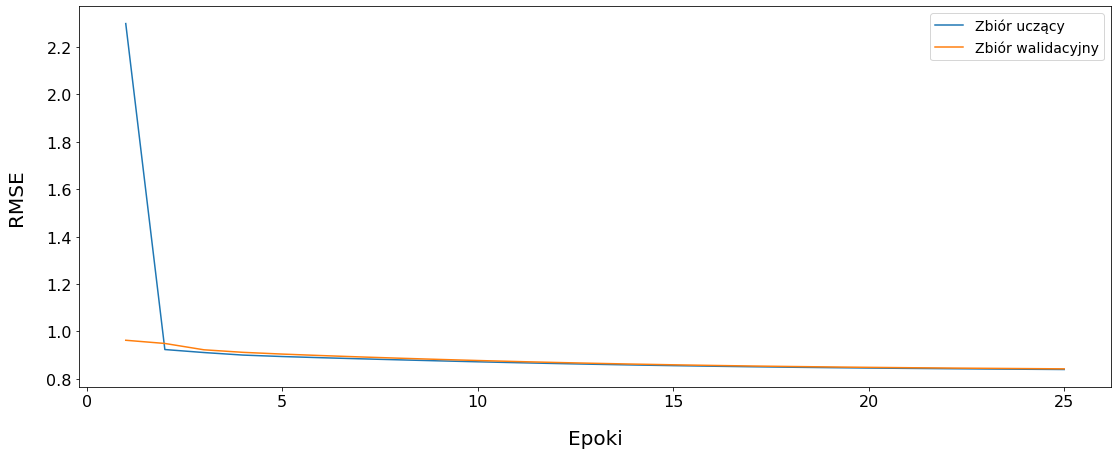

In [ ]:
import matplotlib.pyplot as plt

num_validation_runs = len(history.history["val_root_mean_squared_error"])
num_training_runs = len(history.history["root_mean_squared_error"])


epochs_val = [(x + 1)* 1 for x in range(num_validation_runs)]
epochs_train = [(x + 1)* 1 for x in range(num_training_runs)]


rmse_val = history.history["val_root_mean_squared_error"]
rmse_train = history.history["root_mean_squared_error"]


fig = plt.gcf()
fig.set_size_inches(18.5, 7)
plt.rcParams['axes.titlepad'] = 20

plt.plot(epochs_train, rmse_train, label='Zbiór uczący')
plt.plot(epochs_val, rmse_val, label='Zbiór walidacyjny')

plt.xlabel("Epoki", fontsize=20, labelpad=20)
plt.ylabel("RMSE", fontsize=20, labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)

# plt.title("Wykres zależności błędu od epok", fontsize=20)
plt.show()
# fig.savefig("./drive/MyDrive/Colab Notebooks/Recipes_new/Data/TFRS/features/retrieval/20_10/model_4/accuracy100_vs_epochs.png", dpi=100)

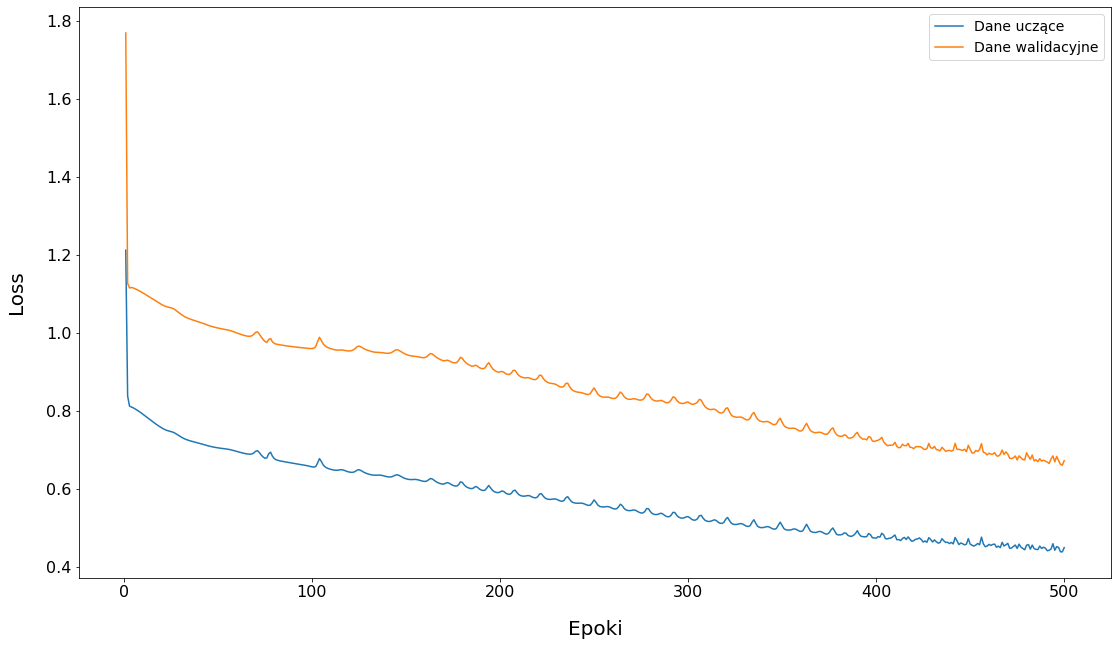

In [ ]:
import matplotlib.pyplot as plt

num_validation_runs = len(history.history["total_loss"])
num_training_runs = len(history.history["val_total_loss"])


epochs_val = [(x + 1)* 1 for x in range(num_validation_runs)]# [:100]
epochs_train = [(x + 1)* 1 for x in range(num_training_runs)] #[:100]


loss_val = np.array(history.history["val_total_loss"])#[:100]-0.25
loss_train = np.array(history.history["total_loss"])#[:100]


fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.rcParams['axes.titlepad'] = 20

plt.plot(epochs_train, loss_train, label='Dane uczące')
plt.plot(epochs_val, loss_val, label='Dane walidacyjne')

plt.xlabel("Epoki", fontsize=20, labelpad=20)
plt.ylabel("Loss", fontsize=20, labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)

# plt.title("Wykres zależności błędu od epok", fontsize=20)
plt.show()
# fig.savefig("./drive/MyDrive/Colab Notebooks/Recipes_new/Data/TFRS/features/retrieval/20_10/model_4/accuracy100_vs_epochs.png", dpi=100)